<h1> Second Round of BERT Training </h1>

In this round, I follow the RoBERTa implementation, which uses dynamic masking and whole-text prediction (rather than NSP). Named entity tokens in the dataset have now been replaced with their BIOES tags. I also add regularization in attempt to balance the distribution of samples across targets in the corpus.


In [208]:
#use pyto_env kernel, pyto env.

import os
import json
import pandas as pd
import importlib
import pickle
import numpy as np

import torch
from torch.optim import AdamW
from torch.utils.data import (TensorDataset, 
                              DataLoader, 
                              RandomSampler, 
                              SequentialSampler)
from torchmetrics import F1Score

from transformers import (AutoModel,
                          AutoConfig,
                          BertTokenizer,
                          BertForMaskedLM,
                          BertForSequenceClassification,
                          RobertaTokenizer, 
                          RobertaModel, 
                          RobertaForSequenceClassification, 
                          RobertaConfig, 
                          RobertaForMaskedLM,
                          get_linear_schedule_with_warmup)

import common
from common import (ClassificationDataset, 
                    BERT_fine_tune_validation, 
                    BERT_fine_tune_train, 
                    plot_confusion_matrix,
                   train_test_val_split)

import common_metrics
from common_metrics import plot_one_vs_one_roc

In [209]:
project_dir = "/Users/paulp/Library/CloudStorage/OneDrive-UniversityofEasternFinland/UEF/Thesis"
data_dir = os.path.join(project_dir,"Data")
model_dir = os.path.join(project_dir, "Models")
roberta_dir = os.path.join(model_dir, 'robert-classifier')

os.chdir(data_dir)

#L1 to integer map for loading categories into BERT
with open('target_idx.json') as f:
    data = f.read()
target_idx = json.loads(data)
idx_target = {target_idx[a]:a for a in target_idx.keys()}


# additional special tokens
with open('spec_tokens_ne.txt', 'rb') as file:
    spec_tokens = pickle.load(file)
spec_tokens = [a for a in spec_tokens if '-' not in a]

# Load from data directory
ds_tr = pd.read_csv('train.csv')
ds_vl = pd.read_csv('validation.csv')
ds_ts = pd.read_csv('test.csv')

#Uncomment below to generate new random datasets

#masked_dataset = pd.read_csv('masked_data_set.csv', index_col=0)
#ds_tr, ds_vl, ds_ts = train_test_val_split(masked_dataset)
#save
#ds_tr.to_csv(os.path.join(data_dir, 'train.csv'))
#ds_vl.to_csv(os.path.join(data_dir, 'validation.csv'))
#ds_ts.to_csv(os.path.join(data_dir, 'test.csv'))

In [210]:
# hyperparameters and variables universal to this project

max_len = 512
batch_size = 2
lr = 1e-5
n_warmup = 0
epochs = 6
n_classes = len(target_idx.keys())
metric = F1Score(num_classes=n_classes)

use_mps = torch.has_mps
#device = torch.device('mps' if use_mps else 'cpu') STILL not working
device = torch.device('cpu')


<h1> Customized BERT and RoBERTa </h1>

<h2> Weighted Cross-Entropy Loss </h2>

Swap the loss function in RoBERTa: code below adapted from:
https://github.com/huggingface/transformers/issues/10845

Weighted Cross-Entropy:
https://towardsdatascience.com/handling-class-imbalanced-data-using-a-loss-specifically-made-for-it-6e58fd65ffab
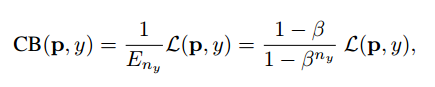
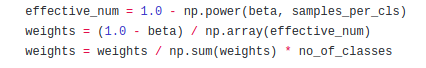

In [211]:
from scipy.special import softmax

In [212]:
# Weights
def get_weights(df, target_idx, beta=0.999, to_tensor = True):
    '''
    get weights for weighted cross-entropy loss.
    method strings are 'eff-no', 'inv-freq', and 'sqrt-inv-frq'
    '''
    samples_per_class = ds_tr['Target'].value_counts()

    effective_num = 1.0 - np.power(beta, samples_per_class)
    class_weights = (1.0 - beta) / effective_num
    class_weights = class_weights / np.sum(class_weights)*n_classes
    # IMPORTANT: connect the weights to the target IDS
    weights = [class_weights[a] for a in target_idx]
    
    if to_tensor:
        weights = torch.tensor(weights).to(torch.float32)
    print(class_weights)
    
    return weights

In [213]:
weights = get_weights(ds_tr, target_idx)
weighted_cross_entropy_loss = nn.CrossEntropyLoss(weight=weights)

GE    0.877503
SP    0.925578
CN    0.947032
RU    1.051821
JP    1.084146
AR    1.113921
Name: Target, dtype: float64


In [216]:
import torch.nn.functional as F
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn

class CustomModel(nn.Module):
    
    def __init__(self, config, num_labels, loss_fn): #checkpoint, num_labels): 
        super(CustomModel,self).__init__() 
        self.num_labels = num_labels 
        #Load Model with config
        self.model = model = AutoModel.from_config(config) # does not load model weights, use 'from pretrained' to 
        self.dropout = nn.Dropout(0.00) 
        self.linear = nn.Linear(512, 1)
        self.layer_norm = nn.LayerNorm([768, 1])
        self.classifier = nn.Linear(768, num_labels) # load and initialize weights

        self.loss_fn = loss_fn

    def forward(self, input_ids=None, token_type_ids = None, attention_mask=None,labels=None):
        #Extract outputs from the MLM model
        outputs = self.model(input_ids=input_ids, token_type_ids = token_type_ids, attention_mask=attention_mask)
        #Get Last hidden state
        sequence_output = self.dropout(outputs['hidden_states'][-1])
        # condense the 512 tokens into 1 dimension
        token_crunch = self.linear(sequence_output.transpose(-2,-1)) 
        # layer norm
        normed = self.layer_norm(token_crunch)
        # condense the features into 6 class values 
        logits = self.classifier(normed.transpose(-2,-1)).squeeze(1)
        
        # calculate losses
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels.long())

        return SequenceClassifierOutput(loss=loss, 
                                        logits=logits, 
                                        hidden_states=outputs.hidden_states, 
                                        attentions=outputs.attentions)

<h2> Roberta </h2>

In [49]:
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base',
                                                                    num_labels = n_classes,
                                                                     attention_probs_dropout_prob = 0.00,
                                                                     hidden_dropout_prob = 0.00,
                                                                    classifier_dropout = 0.0,
                                                                    id2label = idx_target,
                                                                    label2id = target_idx,
                                                                output_attentions = True,
                                                                output_hidden_states = True)

roberta_config = roberta_model.config

#only the config is needed
del(roberta_model)

In [10]:
train_ds_r = ClassificationDataset(ds_tr, roberta_tokenizer, target_idx, max_seq_len=max_len)
val_ds_r = ClassificationDataset(ds_vl, roberta_tokenizer, target_idx, max_seq_len=max_len)
test_ds_r = ClassificationDataset(ds_ts, roberta_tokenizer, target_idx, max_seq_len=max_len)

train_dataloader_r = DataLoader(
    train_ds_r, 
    sampler = RandomSampler(train_ds_r), 
    batch_size=batch_size
)

validation_dataloader_r = DataLoader(
    val_ds_r,
    sampler = RandomSampler(val_ds_r),
    batch_size = batch_size)

test_dataloader_r = DataLoader(
    test_ds_r,
    sampler = RandomSampler(test_ds_r),
    batch_size = batch_size)

NameError: name 'roberta_tokenizer' is not defined

In [8]:
total_steps = len(train_dataloader_r)*epochs

roberta_custom_model = CustomModel(config = roberta_config, 
                            num_labels = n_classes,
                            loss_fn = weighted_cross_entropy_loss)

optim_roberta = AdamW(roberta_custom_model.parameters(), lr=lr)

scheduler = get_linear_schedule_with_warmup(optim_roberta,
                                           num_warmup_steps = n_warmup,
                                           num_training_steps = total_steps)

metric = F1Score(num_classes = n_classes)

NameError: name 'train_dataloader_r' is not defined

In [80]:
stats_roberta = BERT_fine_tune_train(roberta_custom_model,
                                            train_dataloader_r,
                                            validation_dataloader_r,
                                            device = device,
                                            metric = metric,
                                            optimizer = optim_roberta,
                                            scheduler = scheduler,
                                            epochs = epochs,
                                            lr = lr,
                                            n_warmup = n_warmup
                                            )


======== Epoch 1 / 3 ========
Training...
  Batch    50 / 6,888  -  Avg Batch Loss: 1.5241  -  Elapsed: 0:01:14
  Batch   100 / 6,888  -  Avg Batch Loss: 1.6156  -  Elapsed: 0:02:26
  Batch   150 / 6,888  -  Avg Batch Loss: 1.6051  -  Elapsed: 0:03:39
  Batch   200 / 6,888  -  Avg Batch Loss: 1.5048  -  Elapsed: 0:04:53
  Batch   250 / 6,888  -  Avg Batch Loss: 1.6823  -  Elapsed: 0:06:06
  Batch   300 / 6,888  -  Avg Batch Loss: 1.6843  -  Elapsed: 0:07:20
  Batch   350 / 6,888  -  Avg Batch Loss: 1.5491  -  Elapsed: 0:08:33
  Batch   400 / 6,888  -  Avg Batch Loss: 1.4978  -  Elapsed: 0:09:46
  Batch   450 / 6,888  -  Avg Batch Loss: 1.5356  -  Elapsed: 0:11:00
  Batch   500 / 6,888  -  Avg Batch Loss: 1.6013  -  Elapsed: 0:12:13
  Batch   550 / 6,888  -  Avg Batch Loss: 1.5720  -  Elapsed: 0:13:27
  Batch   600 / 6,888  -  Avg Batch Loss: 1.5781  -  Elapsed: 0:14:43
  Batch   650 / 6,888  -  Avg Batch Loss: 1.5589  -  Elapsed: 0:15:56
  Batch   700 / 6,888  -  Avg Batch Loss: 1.514

  Batch 5,900 / 6,888  -  Avg Batch Loss: 1.4999  -  Elapsed: 2:23:53
  Batch 5,950 / 6,888  -  Avg Batch Loss: 1.6246  -  Elapsed: 2:25:06
  Batch 6,000 / 6,888  -  Avg Batch Loss: 1.5387  -  Elapsed: 2:26:18
  Batch 6,050 / 6,888  -  Avg Batch Loss: 1.5731  -  Elapsed: 2:27:31
  Batch 6,100 / 6,888  -  Avg Batch Loss: 1.4381  -  Elapsed: 2:28:43
  Batch 6,150 / 6,888  -  Avg Batch Loss: 1.5818  -  Elapsed: 2:29:56
  Batch 6,200 / 6,888  -  Avg Batch Loss: 1.5048  -  Elapsed: 2:31:08
  Batch 6,250 / 6,888  -  Avg Batch Loss: 1.6097  -  Elapsed: 2:32:20
  Batch 6,300 / 6,888  -  Avg Batch Loss: 1.6164  -  Elapsed: 2:33:33
  Batch 6,350 / 6,888  -  Avg Batch Loss: 1.4449  -  Elapsed: 2:34:45
  Batch 6,400 / 6,888  -  Avg Batch Loss: 1.5648  -  Elapsed: 2:35:58
  Batch 6,450 / 6,888  -  Avg Batch Loss: 1.5996  -  Elapsed: 2:37:10
  Batch 6,500 / 6,888  -  Avg Batch Loss: 1.7198  -  Elapsed: 2:38:23
  Batch 6,550 / 6,888  -  Avg Batch Loss: 1.6271  -  Elapsed: 2:39:35
  Batch 6,600 / 6,88

  Batch 4,750 / 6,888  -  Avg Batch Loss: 1.4928  -  Elapsed: 1:54:48
  Batch 4,800 / 6,888  -  Avg Batch Loss: 1.5520  -  Elapsed: 1:56:00
  Batch 4,850 / 6,888  -  Avg Batch Loss: 1.5561  -  Elapsed: 1:57:13
  Batch 4,900 / 6,888  -  Avg Batch Loss: 1.5497  -  Elapsed: 1:58:25
  Batch 4,950 / 6,888  -  Avg Batch Loss: 1.5854  -  Elapsed: 1:59:38
  Batch 5,000 / 6,888  -  Avg Batch Loss: 1.6125  -  Elapsed: 2:00:50
  Batch 5,050 / 6,888  -  Avg Batch Loss: 1.4893  -  Elapsed: 2:02:03
  Batch 5,100 / 6,888  -  Avg Batch Loss: 1.7409  -  Elapsed: 2:03:15
  Batch 5,150 / 6,888  -  Avg Batch Loss: 1.5853  -  Elapsed: 2:04:28
  Batch 5,200 / 6,888  -  Avg Batch Loss: 1.6455  -  Elapsed: 2:05:40
  Batch 5,250 / 6,888  -  Avg Batch Loss: 1.6132  -  Elapsed: 2:06:53
  Batch 5,300 / 6,888  -  Avg Batch Loss: 1.3986  -  Elapsed: 2:08:05
  Batch 5,350 / 6,888  -  Avg Batch Loss: 1.6443  -  Elapsed: 2:09:18
  Batch 5,400 / 6,888  -  Avg Batch Loss: 1.5737  -  Elapsed: 2:10:30
  Batch 5,450 / 6,88

  Batch 3,600 / 6,888  -  Avg Batch Loss: 1.5300  -  Elapsed: 1:27:00
  Batch 3,650 / 6,888  -  Avg Batch Loss: 1.6177  -  Elapsed: 1:28:12
  Batch 3,700 / 6,888  -  Avg Batch Loss: 1.5353  -  Elapsed: 1:29:25
  Batch 3,750 / 6,888  -  Avg Batch Loss: 1.5151  -  Elapsed: 1:30:37
  Batch 3,800 / 6,888  -  Avg Batch Loss: 1.5402  -  Elapsed: 1:31:49
  Batch 3,850 / 6,888  -  Avg Batch Loss: 1.5183  -  Elapsed: 1:33:02
  Batch 3,900 / 6,888  -  Avg Batch Loss: 1.5374  -  Elapsed: 1:34:14
  Batch 3,950 / 6,888  -  Avg Batch Loss: 1.5538  -  Elapsed: 1:35:27
  Batch 4,000 / 6,888  -  Avg Batch Loss: 1.5944  -  Elapsed: 1:36:39
  Batch 4,050 / 6,888  -  Avg Batch Loss: 1.5196  -  Elapsed: 1:37:51
  Batch 4,100 / 6,888  -  Avg Batch Loss: 1.5622  -  Elapsed: 1:39:03
  Batch 4,150 / 6,888  -  Avg Batch Loss: 1.4991  -  Elapsed: 1:40:15
  Batch 4,200 / 6,888  -  Avg Batch Loss: 1.5627  -  Elapsed: 1:41:28
  Batch 4,250 / 6,888  -  Avg Batch Loss: 1.5621  -  Elapsed: 1:42:40
  Batch 4,300 / 6,88

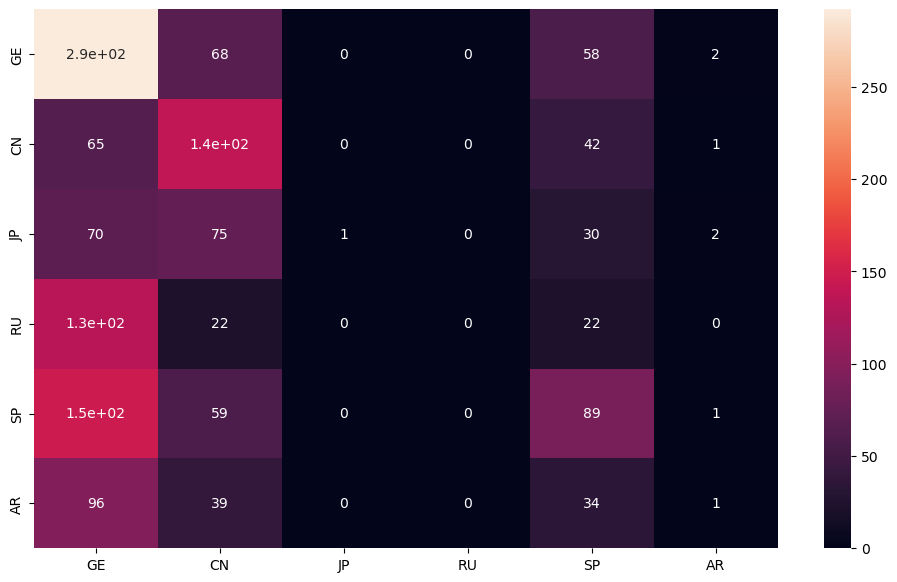

In [82]:
plot_confusion_matrix(stats_roberta[-1]['val_stats']['y_true'], 
                      stats_roberta[-1]['val_stats']['y_pred'], 
                      idx_target)

In [162]:
torch.save(roberta_custom_model, os.path.join(model_dir, 'roberta_6e_1e-5_wcel.pt'))

In [84]:
# run on test set 
test_stats = BERT_fine_tune_validation(roberta_custom_model,
                         test_dataloader_r,
                         device = device,
                         metric = metric)


Running Validation...
  Accuracy: 0.37
  Validation Loss: 1.59
  Validation F1 Score: 0.373
  Validation took: 0:05:39


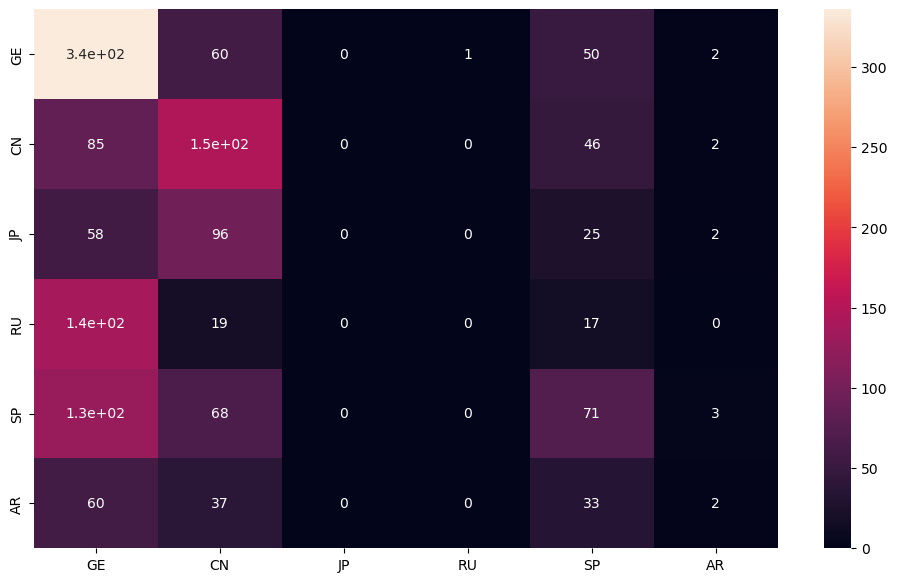

In [85]:
plot_confusion_matrix(test_stats['y_true'], 
                      test_stats['y_pred'], 
                      idx_target)

<h3> findings </h3>

Despite the improvements mentioned in RoBERTa's documentation, the classifier failed to deliver on the dataset. Possibly, byte-pair encodings, which recognize word parts, are too granular and not very informative: calculating features at the subword level takes a lot of time and energy from the model, with little payoff. Also, 512 length embeddings are not actually 512 'tokens' as they are in BERT, but 512 word and subword units, including spaces between tokens: so less of each sample was used in inference, and this impacted results.

<h2> BERT Custom </h2>

In [214]:

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased',
                                              additional_special_tokens = spec_tokens)

bert_model = BertForSequenceClassification.from_pretrained('bert-base-cased', 
                                                          num_labels = n_classes,
                                                          attention_probs_dropout_prob = 0.00,
                                                          hidden_dropout_prob = 0.00,
                                                          classifier_dropout = 0.0,
                                                          id2label = idx_target,
                                                          label2id = target_idx,
                                                          output_attentions = True,
                                                          output_hidden_states = True)

bert_model.resize_token_embeddings(len(bert_tokenizer))
bert_config = bert_model.config
del(bert_model)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceCl

In [215]:
train_ds_b = ClassificationDataset(ds_tr, bert_tokenizer, target_idx, max_seq_len=max_len)
val_ds_b = ClassificationDataset(ds_vl, bert_tokenizer, target_idx, max_seq_len=max_len)
test_ds_b = ClassificationDataset(ds_ts, bert_tokenizer, target_idx, max_seq_len=max_len)

train_dataloader_b = DataLoader(
    train_ds_b, 
    sampler = RandomSampler(train_ds_b), 
    batch_size=batch_size
)

validation_dataloader_b = DataLoader(
    val_ds_b,
    sampler = RandomSampler(val_ds_b),
    batch_size = batch_size)

test_dataloader_b = DataLoader(
    test_ds_b,
    sampler = RandomSampler(test_ds_b),
    batch_size = batch_size)

In [222]:
total_steps = len(train_dataloader_b)*epochs

bert_custom_model = CustomModel(bert_config,
                               num_labels = n_classes,
                               loss_fn = weighted_cross_entropy_loss)

optim_bert = AdamW(bert_custom_model.parameters(), lr=lr)

scheduler = get_linear_schedule_with_warmup(optim_bert,
                                           num_warmup_steps = n_warmup,
                                           num_training_steps = total_steps)

metric = F1Score(num_classes = n_classes)

In [223]:
stats_bert = BERT_fine_tune_train(bert_custom_model,
                    train_dataloader_b,
                    validation_dataloader_b,
                    device = device,
                    metric = metric,
                    optimizer = optim_bert,
                    scheduler = scheduler,
                    epochs = epochs,
                    lr = lr,
                    n_warmup = n_warmup
                    )


======== Epoch 1 / 6 ========
Training...
  Batch    50 / 6,889  -  Avg Batch Loss: 2.1403  -  Elapsed: 0:01:13
  Batch   100 / 6,889  -  Avg Batch Loss: 1.9258  -  Elapsed: 0:02:30
  Batch   150 / 6,889  -  Avg Batch Loss: 1.9047  -  Elapsed: 0:03:44
  Batch   200 / 6,889  -  Avg Batch Loss: 2.0137  -  Elapsed: 0:04:57
  Batch   250 / 6,889  -  Avg Batch Loss: 1.8265  -  Elapsed: 0:06:13
  Batch   300 / 6,889  -  Avg Batch Loss: 1.8315  -  Elapsed: 0:07:28
  Batch   350 / 6,889  -  Avg Batch Loss: 1.8640  -  Elapsed: 0:08:41
  Batch   400 / 6,889  -  Avg Batch Loss: 1.8780  -  Elapsed: 0:09:56
  Batch   450 / 6,889  -  Avg Batch Loss: 1.8139  -  Elapsed: 0:11:11
  Batch   500 / 6,889  -  Avg Batch Loss: 1.8444  -  Elapsed: 0:12:26
  Batch   550 / 6,889  -  Avg Batch Loss: 1.8672  -  Elapsed: 0:13:41
  Batch   600 / 6,889  -  Avg Batch Loss: 1.8797  -  Elapsed: 0:14:53
  Batch   650 / 6,889  -  Avg Batch Loss: 1.8387  -  Elapsed: 0:16:10
  Batch   700 / 6,889  -  Avg Batch Loss: 1.859

  Batch 5,900 / 6,889  -  Avg Batch Loss: 1.5947  -  Elapsed: 2:29:05
  Batch 5,950 / 6,889  -  Avg Batch Loss: 1.6267  -  Elapsed: 2:30:18
  Batch 6,000 / 6,889  -  Avg Batch Loss: 1.6354  -  Elapsed: 2:31:30
  Batch 6,050 / 6,889  -  Avg Batch Loss: 1.5548  -  Elapsed: 2:32:42
  Batch 6,100 / 6,889  -  Avg Batch Loss: 1.5785  -  Elapsed: 2:33:55
  Batch 6,150 / 6,889  -  Avg Batch Loss: 1.6303  -  Elapsed: 2:35:07
  Batch 6,200 / 6,889  -  Avg Batch Loss: 1.5400  -  Elapsed: 2:36:20
  Batch 6,250 / 6,889  -  Avg Batch Loss: 1.5530  -  Elapsed: 2:37:32
  Batch 6,300 / 6,889  -  Avg Batch Loss: 1.5186  -  Elapsed: 2:38:45
  Batch 6,350 / 6,889  -  Avg Batch Loss: 1.5001  -  Elapsed: 2:39:58
  Batch 6,400 / 6,889  -  Avg Batch Loss: 1.5823  -  Elapsed: 2:41:10
  Batch 6,450 / 6,889  -  Avg Batch Loss: 1.5517  -  Elapsed: 2:42:24
  Batch 6,500 / 6,889  -  Avg Batch Loss: 1.4853  -  Elapsed: 2:43:36
  Batch 6,550 / 6,889  -  Avg Batch Loss: 1.6732  -  Elapsed: 2:44:49
  Batch 6,600 / 6,88

  Batch 4,750 / 6,889  -  Avg Batch Loss: 1.5959  -  Elapsed: 1:55:25
  Batch 4,800 / 6,889  -  Avg Batch Loss: 1.4693  -  Elapsed: 1:56:38
  Batch 4,850 / 6,889  -  Avg Batch Loss: 1.4438  -  Elapsed: 1:57:52
  Batch 4,900 / 6,889  -  Avg Batch Loss: 1.2366  -  Elapsed: 1:59:05
  Batch 4,950 / 6,889  -  Avg Batch Loss: 1.4830  -  Elapsed: 2:00:18
  Batch 5,000 / 6,889  -  Avg Batch Loss: 1.3160  -  Elapsed: 2:01:32
  Batch 5,050 / 6,889  -  Avg Batch Loss: 1.4618  -  Elapsed: 2:02:45
  Batch 5,100 / 6,889  -  Avg Batch Loss: 1.4343  -  Elapsed: 2:03:58
  Batch 5,150 / 6,889  -  Avg Batch Loss: 1.5908  -  Elapsed: 2:05:12
  Batch 5,200 / 6,889  -  Avg Batch Loss: 1.3279  -  Elapsed: 2:06:25
  Batch 5,250 / 6,889  -  Avg Batch Loss: 1.3656  -  Elapsed: 2:07:39
  Batch 5,300 / 6,889  -  Avg Batch Loss: 1.4468  -  Elapsed: 2:08:52
  Batch 5,350 / 6,889  -  Avg Batch Loss: 1.4043  -  Elapsed: 2:10:06
  Batch 5,400 / 6,889  -  Avg Batch Loss: 1.4368  -  Elapsed: 2:11:20
  Batch 5,450 / 6,88

  Batch 3,600 / 6,889  -  Avg Batch Loss: 1.3953  -  Elapsed: 1:26:57
  Batch 3,650 / 6,889  -  Avg Batch Loss: 1.2468  -  Elapsed: 1:28:10
  Batch 3,700 / 6,889  -  Avg Batch Loss: 1.1166  -  Elapsed: 1:29:21
  Batch 3,750 / 6,889  -  Avg Batch Loss: 1.2095  -  Elapsed: 1:30:34
  Batch 3,800 / 6,889  -  Avg Batch Loss: 1.5669  -  Elapsed: 1:31:46
  Batch 3,850 / 6,889  -  Avg Batch Loss: 1.1069  -  Elapsed: 1:32:58
  Batch 3,900 / 6,889  -  Avg Batch Loss: 1.2179  -  Elapsed: 1:34:11
  Batch 3,950 / 6,889  -  Avg Batch Loss: 1.1537  -  Elapsed: 1:35:22
  Batch 4,000 / 6,889  -  Avg Batch Loss: 1.2361  -  Elapsed: 1:36:34
  Batch 4,050 / 6,889  -  Avg Batch Loss: 1.0114  -  Elapsed: 1:37:47
  Batch 4,100 / 6,889  -  Avg Batch Loss: 1.2805  -  Elapsed: 1:38:58
  Batch 4,150 / 6,889  -  Avg Batch Loss: 1.2042  -  Elapsed: 1:40:11
  Batch 4,200 / 6,889  -  Avg Batch Loss: 1.1486  -  Elapsed: 1:41:22
  Batch 4,250 / 6,889  -  Avg Batch Loss: 1.0524  -  Elapsed: 1:42:34
  Batch 4,300 / 6,88

  Batch 2,450 / 6,889  -  Avg Batch Loss: 1.0763  -  Elapsed: 0:58:52
  Batch 2,500 / 6,889  -  Avg Batch Loss: 0.7970  -  Elapsed: 1:00:04
  Batch 2,550 / 6,889  -  Avg Batch Loss: 1.1172  -  Elapsed: 1:01:16
  Batch 2,600 / 6,889  -  Avg Batch Loss: 0.8549  -  Elapsed: 1:02:29
  Batch 2,650 / 6,889  -  Avg Batch Loss: 0.9643  -  Elapsed: 1:03:40
  Batch 2,700 / 6,889  -  Avg Batch Loss: 0.9939  -  Elapsed: 1:04:52
  Batch 2,750 / 6,889  -  Avg Batch Loss: 0.9125  -  Elapsed: 1:06:05
  Batch 2,800 / 6,889  -  Avg Batch Loss: 1.0976  -  Elapsed: 1:07:16
  Batch 2,850 / 6,889  -  Avg Batch Loss: 0.7334  -  Elapsed: 1:08:29
  Batch 2,900 / 6,889  -  Avg Batch Loss: 0.8587  -  Elapsed: 1:09:40
  Batch 2,950 / 6,889  -  Avg Batch Loss: 1.1039  -  Elapsed: 1:10:52
  Batch 3,000 / 6,889  -  Avg Batch Loss: 0.6275  -  Elapsed: 1:12:04
  Batch 3,050 / 6,889  -  Avg Batch Loss: 0.8407  -  Elapsed: 1:13:16
  Batch 3,100 / 6,889  -  Avg Batch Loss: 0.9861  -  Elapsed: 1:14:29
  Batch 3,150 / 6,88

  Batch 1,300 / 6,889  -  Avg Batch Loss: 0.4509  -  Elapsed: 0:31:16
  Batch 1,350 / 6,889  -  Avg Batch Loss: 0.6430  -  Elapsed: 0:32:27
  Batch 1,400 / 6,889  -  Avg Batch Loss: 0.5349  -  Elapsed: 0:33:40
  Batch 1,450 / 6,889  -  Avg Batch Loss: 0.6542  -  Elapsed: 0:34:53
  Batch 1,500 / 6,889  -  Avg Batch Loss: 0.7710  -  Elapsed: 0:36:04
  Batch 1,550 / 6,889  -  Avg Batch Loss: 0.6809  -  Elapsed: 0:37:17
  Batch 1,600 / 6,889  -  Avg Batch Loss: 0.9312  -  Elapsed: 0:38:28
  Batch 1,650 / 6,889  -  Avg Batch Loss: 0.6604  -  Elapsed: 0:39:41
  Batch 1,700 / 6,889  -  Avg Batch Loss: 0.4191  -  Elapsed: 0:40:52
  Batch 1,750 / 6,889  -  Avg Batch Loss: 0.8283  -  Elapsed: 0:42:05
  Batch 1,800 / 6,889  -  Avg Batch Loss: 0.6770  -  Elapsed: 0:43:17
  Batch 1,850 / 6,889  -  Avg Batch Loss: 0.6843  -  Elapsed: 0:44:28
  Batch 1,900 / 6,889  -  Avg Batch Loss: 0.5504  -  Elapsed: 0:45:41
  Batch 1,950 / 6,889  -  Avg Batch Loss: 0.7243  -  Elapsed: 0:46:52
  Batch 2,000 / 6,88

  Batch   150 / 6,889  -  Avg Batch Loss: 0.3700  -  Elapsed: 0:03:36
  Batch   200 / 6,889  -  Avg Batch Loss: 0.4390  -  Elapsed: 0:04:48
  Batch   250 / 6,889  -  Avg Batch Loss: 0.3122  -  Elapsed: 0:06:00
  Batch   300 / 6,889  -  Avg Batch Loss: 0.5175  -  Elapsed: 0:07:12
  Batch   350 / 6,889  -  Avg Batch Loss: 0.3338  -  Elapsed: 0:08:24
  Batch   400 / 6,889  -  Avg Batch Loss: 0.2741  -  Elapsed: 0:09:36
  Batch   450 / 6,889  -  Avg Batch Loss: 0.4366  -  Elapsed: 0:10:48
  Batch   500 / 6,889  -  Avg Batch Loss: 0.5530  -  Elapsed: 0:12:01
  Batch   550 / 6,889  -  Avg Batch Loss: 0.2861  -  Elapsed: 0:13:13
  Batch   600 / 6,889  -  Avg Batch Loss: 0.2926  -  Elapsed: 0:14:26
  Batch   650 / 6,889  -  Avg Batch Loss: 0.1998  -  Elapsed: 0:15:38
  Batch   700 / 6,889  -  Avg Batch Loss: 0.5334  -  Elapsed: 0:16:51
  Batch   750 / 6,889  -  Avg Batch Loss: 0.3606  -  Elapsed: 0:18:04
  Batch   800 / 6,889  -  Avg Batch Loss: 0.3753  -  Elapsed: 0:19:15
  Batch   850 / 6,88

  Batch 6,050 / 6,889  -  Avg Batch Loss: 0.5879  -  Elapsed: 2:25:28
  Batch 6,100 / 6,889  -  Avg Batch Loss: 0.2473  -  Elapsed: 2:26:41
  Batch 6,150 / 6,889  -  Avg Batch Loss: 0.4574  -  Elapsed: 2:27:54
  Batch 6,200 / 6,889  -  Avg Batch Loss: 0.3789  -  Elapsed: 2:29:05
  Batch 6,250 / 6,889  -  Avg Batch Loss: 0.2517  -  Elapsed: 2:30:18
  Batch 6,300 / 6,889  -  Avg Batch Loss: 0.3958  -  Elapsed: 2:31:29
  Batch 6,350 / 6,889  -  Avg Batch Loss: 0.5319  -  Elapsed: 2:32:42
  Batch 6,400 / 6,889  -  Avg Batch Loss: 0.0582  -  Elapsed: 2:33:54
  Batch 6,450 / 6,889  -  Avg Batch Loss: 0.5796  -  Elapsed: 2:35:06
  Batch 6,500 / 6,889  -  Avg Batch Loss: 0.4210  -  Elapsed: 2:36:18
  Batch 6,550 / 6,889  -  Avg Batch Loss: 0.4535  -  Elapsed: 2:37:30
  Batch 6,600 / 6,889  -  Avg Batch Loss: 0.4638  -  Elapsed: 2:38:42
  Batch 6,650 / 6,889  -  Avg Batch Loss: 0.1664  -  Elapsed: 2:39:55
  Batch 6,700 / 6,889  -  Avg Batch Loss: 0.3096  -  Elapsed: 2:41:06
  Batch 6,750 / 6,88

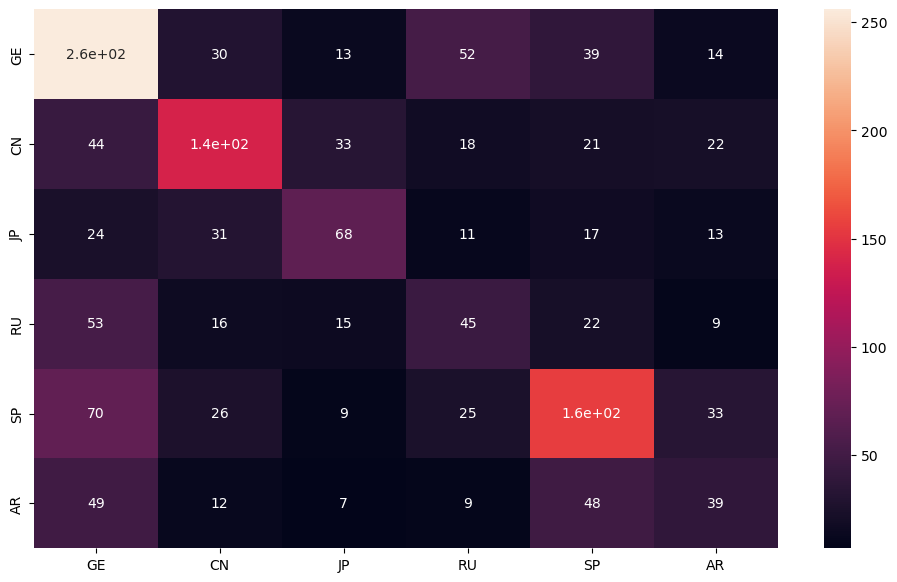

In [224]:
plot_confusion_matrix(stats_bert[-1]['val_stats']['y_true'], 
                      stats_bert[-1]['val_stats']['y_pred'], 
                      idx_target)


Running Validation...
  Accuracy: 0.45
  Validation Loss: 4.26
  Validation F1 Score: 0.452
  Validation took: 0:05:38


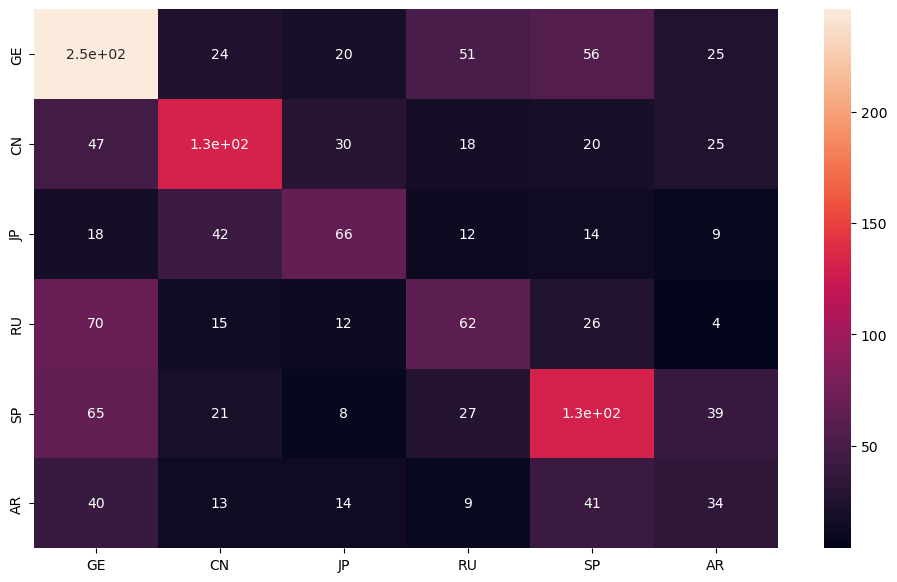

In [228]:
# run test set
test_stats_b = BERT_fine_tune_validation(bert_custom_model,
                         test_dataloader_b,
                         device = device,
                         metric = metric)

plot_confusion_matrix(test_stats_b['y_true'], 
                      test_stats_b['y_pred'], 
                      idx_target)

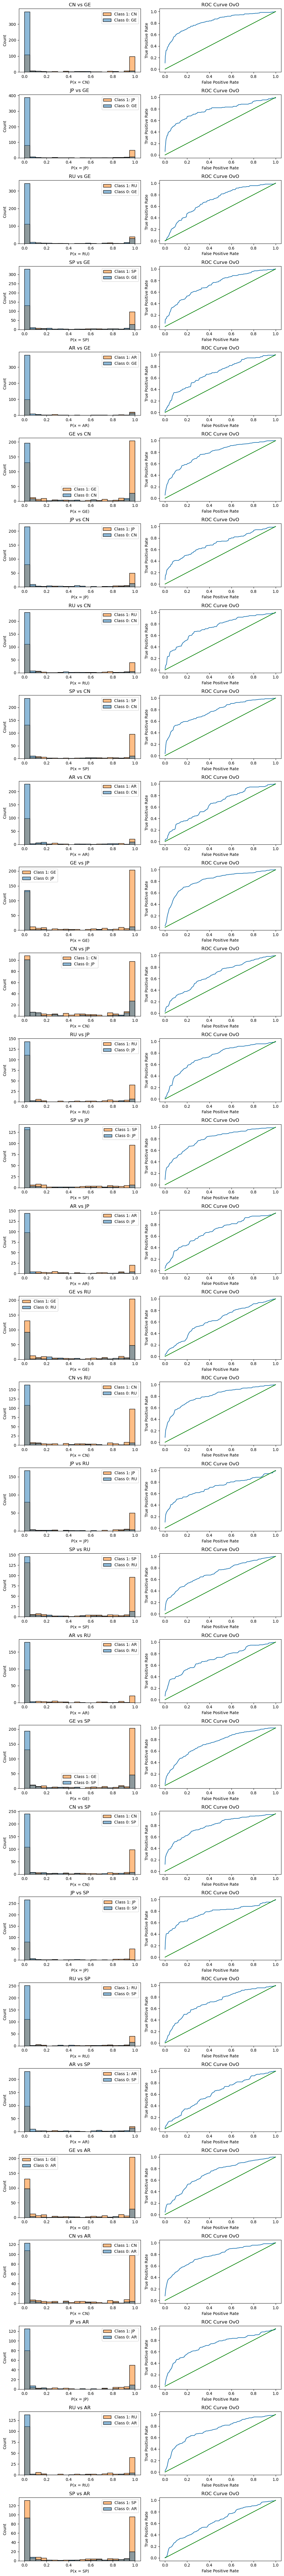

In [229]:
plot_one_vs_one_roc(test_stats_b['y_true'], 
                    test_stats_b['logits'], 
                    idx_target)

In [251]:
# save model
last = stats_bert[-1]
torch.save({
            'epoch': last['epoch'],
            'model_state_dict': bert_custom_model.state_dict(),
            'optimizer_state_dict': optim_bert.state_dict(),
            'loss': last['train_stats']['avg_train_loss'],
            }, os.path.join(model_dir, '2_bert_6e_1e-5_wcel.tar'))

In [252]:
bert_model = CustomModel(bert_config,
                               num_labels = n_classes,
                               loss_fn = weighted_cross_entropy_loss)

lr = 2e-6 # step down lr 
bert_optim = AdamW(bert_model.parameters(), lr=lr)

checkpoint = torch.load(os.path.join(model_dir, '2_bert_6e_1e-5_wcel.tar'))
bert_model.load_state_dict(checkpoint['model_state_dict'])
bert_optim.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
#loss = checkpoint['loss']

bert_model.train()

CustomModel(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29003, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [257]:
lr = 1e-6
epochs = 3
bert_stats = BERT_fine_tune_train(bert_model,
                    train_dataloader_b,
                    validation_dataloader_b,
                    device = device,
                    metric = metric,
                    optimizer = bert_optim,
                    scheduler = scheduler,
                    epochs = epochs,
                    lr = lr,
                    n_warmup = n_warmup
                    )


======== Epoch 1 / 3 ========
Training...
  Batch    50 / 6,889  -  Avg Batch Loss: 0.1198  -  Elapsed: 0:01:16
  Batch   100 / 6,889  -  Avg Batch Loss: 0.1006  -  Elapsed: 0:02:30
  Batch   150 / 6,889  -  Avg Batch Loss: 0.1252  -  Elapsed: 0:03:49
  Batch   200 / 6,889  -  Avg Batch Loss: 0.2643  -  Elapsed: 0:05:04
  Batch   250 / 6,889  -  Avg Batch Loss: 0.2378  -  Elapsed: 0:06:19
  Batch   300 / 6,889  -  Avg Batch Loss: 0.4079  -  Elapsed: 0:07:31
  Batch   350 / 6,889  -  Avg Batch Loss: 0.2095  -  Elapsed: 0:08:44
  Batch   400 / 6,889  -  Avg Batch Loss: 0.1606  -  Elapsed: 0:09:57
  Batch   450 / 6,889  -  Avg Batch Loss: 0.2525  -  Elapsed: 0:11:08
  Batch   500 / 6,889  -  Avg Batch Loss: 0.1099  -  Elapsed: 0:12:21
  Batch   550 / 6,889  -  Avg Batch Loss: 0.1020  -  Elapsed: 0:13:33
  Batch   600 / 6,889  -  Avg Batch Loss: 0.1424  -  Elapsed: 0:14:45
  Batch   650 / 6,889  -  Avg Batch Loss: 0.1849  -  Elapsed: 0:15:57
  Batch   700 / 6,889  -  Avg Batch Loss: 0.322

  Batch 5,900 / 6,889  -  Avg Batch Loss: 0.2604  -  Elapsed: 2:23:37
  Batch 5,950 / 6,889  -  Avg Batch Loss: 0.2618  -  Elapsed: 2:24:49
  Batch 6,000 / 6,889  -  Avg Batch Loss: 0.1973  -  Elapsed: 2:26:00
  Batch 6,050 / 6,889  -  Avg Batch Loss: 0.2497  -  Elapsed: 2:27:11
  Batch 6,100 / 6,889  -  Avg Batch Loss: 0.3343  -  Elapsed: 2:28:22
  Batch 6,150 / 6,889  -  Avg Batch Loss: 0.2217  -  Elapsed: 2:29:35
  Batch 6,200 / 6,889  -  Avg Batch Loss: 0.2664  -  Elapsed: 2:30:48
  Batch 6,250 / 6,889  -  Avg Batch Loss: 0.2193  -  Elapsed: 2:32:00
  Batch 6,300 / 6,889  -  Avg Batch Loss: 0.3987  -  Elapsed: 2:33:13
  Batch 6,350 / 6,889  -  Avg Batch Loss: 0.0596  -  Elapsed: 2:34:25
  Batch 6,400 / 6,889  -  Avg Batch Loss: 0.2386  -  Elapsed: 2:35:37
  Batch 6,450 / 6,889  -  Avg Batch Loss: 0.1018  -  Elapsed: 2:36:50
  Batch 6,500 / 6,889  -  Avg Batch Loss: 0.1649  -  Elapsed: 2:38:03
  Batch 6,550 / 6,889  -  Avg Batch Loss: 0.3271  -  Elapsed: 2:39:15
  Batch 6,600 / 6,88

  Batch 4,750 / 6,889  -  Avg Batch Loss: 0.2311  -  Elapsed: 3:06:04
  Batch 4,800 / 6,889  -  Avg Batch Loss: 0.3257  -  Elapsed: 3:07:15
  Batch 4,850 / 6,889  -  Avg Batch Loss: 0.2299  -  Elapsed: 3:08:26
  Batch 4,900 / 6,889  -  Avg Batch Loss: 0.1718  -  Elapsed: 3:09:36
  Batch 4,950 / 6,889  -  Avg Batch Loss: 0.3840  -  Elapsed: 3:10:47
  Batch 5,000 / 6,889  -  Avg Batch Loss: 0.0895  -  Elapsed: 3:11:57
  Batch 5,050 / 6,889  -  Avg Batch Loss: 0.1971  -  Elapsed: 3:13:07
  Batch 5,100 / 6,889  -  Avg Batch Loss: 0.3634  -  Elapsed: 3:14:19
  Batch 5,150 / 6,889  -  Avg Batch Loss: 0.2608  -  Elapsed: 3:15:29
  Batch 5,200 / 6,889  -  Avg Batch Loss: 0.2372  -  Elapsed: 3:16:40
  Batch 5,250 / 6,889  -  Avg Batch Loss: 0.2919  -  Elapsed: 3:17:53
  Batch 5,300 / 6,889  -  Avg Batch Loss: 0.0641  -  Elapsed: 3:19:09
  Batch 5,350 / 6,889  -  Avg Batch Loss: 0.2267  -  Elapsed: 3:20:26
  Batch 5,400 / 6,889  -  Avg Batch Loss: 0.4109  -  Elapsed: 3:21:44
  Batch 5,450 / 6,88

  Batch 3,600 / 6,889  -  Avg Batch Loss: 0.1865  -  Elapsed: 1:28:02
  Batch 3,650 / 6,889  -  Avg Batch Loss: 0.1618  -  Elapsed: 1:29:14
  Batch 3,700 / 6,889  -  Avg Batch Loss: 0.1592  -  Elapsed: 1:30:26
  Batch 3,750 / 6,889  -  Avg Batch Loss: 0.2014  -  Elapsed: 1:31:41
  Batch 3,800 / 6,889  -  Avg Batch Loss: 0.1979  -  Elapsed: 1:32:58
  Batch 3,850 / 6,889  -  Avg Batch Loss: 0.1896  -  Elapsed: 1:34:14
  Batch 3,900 / 6,889  -  Avg Batch Loss: 0.2363  -  Elapsed: 1:35:31
  Batch 3,950 / 6,889  -  Avg Batch Loss: 0.3684  -  Elapsed: 1:36:47
  Batch 4,000 / 6,889  -  Avg Batch Loss: 0.1430  -  Elapsed: 1:38:03
  Batch 4,050 / 6,889  -  Avg Batch Loss: 0.1758  -  Elapsed: 1:39:19
  Batch 4,100 / 6,889  -  Avg Batch Loss: 0.3645  -  Elapsed: 1:40:35
  Batch 4,150 / 6,889  -  Avg Batch Loss: 0.3532  -  Elapsed: 1:41:51
  Batch 4,200 / 6,889  -  Avg Batch Loss: 0.2122  -  Elapsed: 1:43:07
  Batch 4,250 / 6,889  -  Avg Batch Loss: 0.2499  -  Elapsed: 1:44:22
  Batch 4,300 / 6,88


Running Validation...
  Accuracy: 0.45
  Validation Loss: 4.27
  Validation F1 Score: 0.452
  Validation took: 0:05:42


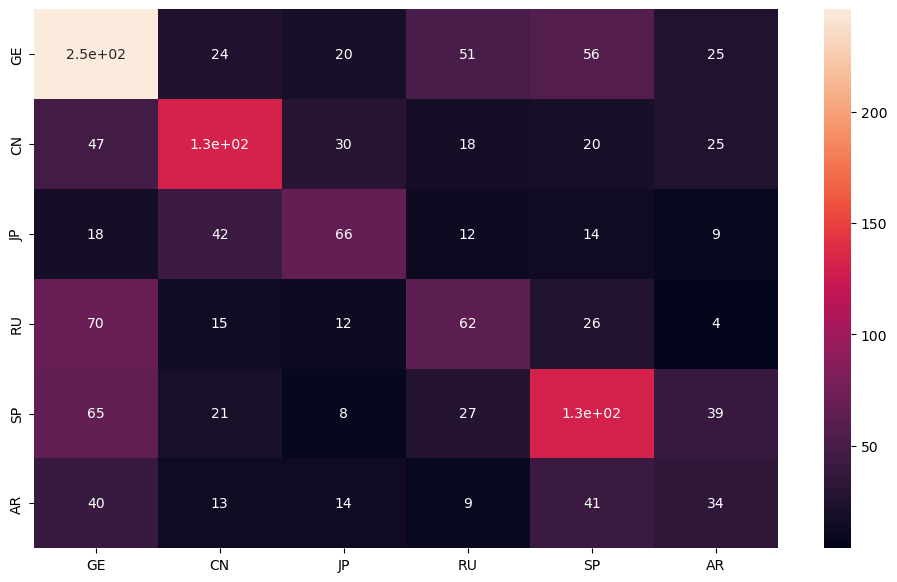

In [258]:
# run test set
test_stats_c = BERT_fine_tune_validation(bert_custom_model,
                         test_dataloader_b,
                         device = device,
                         metric = metric)

plot_confusion_matrix(test_stats_b['y_true'], 
                      test_stats_b['y_pred'], 
                      idx_target)

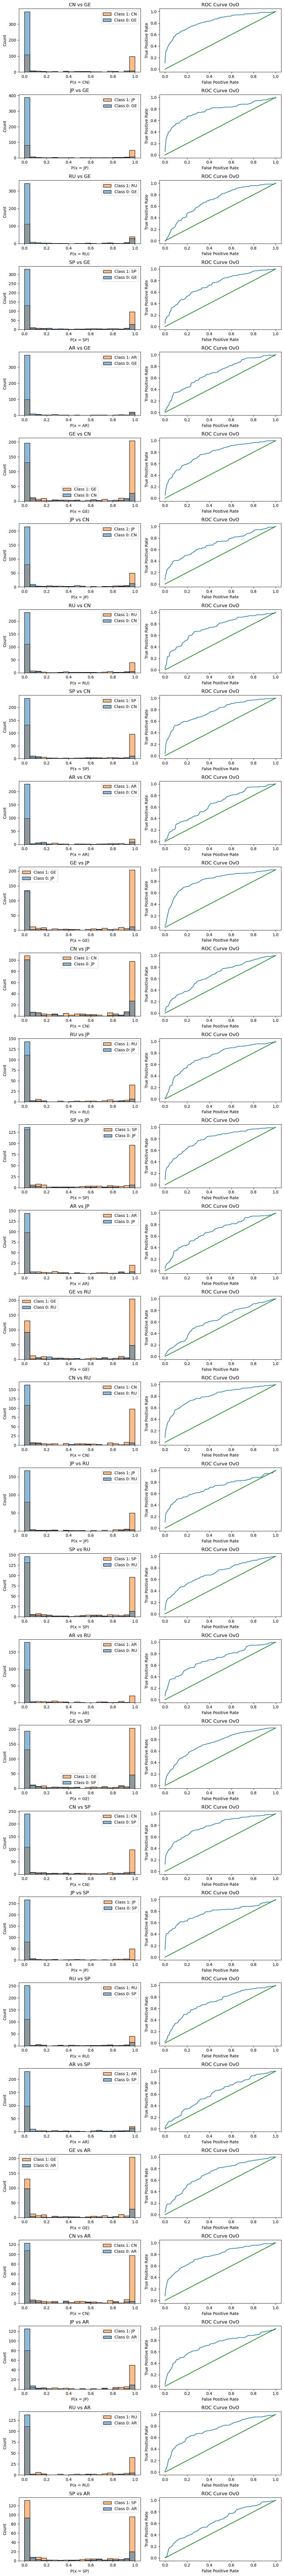

In [259]:
plot_one_vs_one_roc(test_stats_c['y_true'], 
                    test_stats_c['logits'], 
                    idx_target)

<h3> Findings </h3>

Weighted cross-entropy, additional data from TOEFLL11, and data cleaning are likely responsible for the improvement over initial BERT. As this model represents roughly 50 percent accuracy across 6 categories, this BERT will be used as the baseline against which other models are compared. 

It may also be the case that the custom classification head, which squeezed out token representations and focused on d = 768 embedding features allowed the backpropagation to home in on feature-wise impact.

In further exploration, using an exponential learning rate scheduler could help with the plateau that occurred around 6 epochs. However, although the lr was decreased from 1e-5 to 3e-6 at this point, no observable gains were recorded.

<h3> Next steps </h3>

Using Graph Neural Networks to build a model which takes the same max_len and word embedding depth. If possible, the classification head may be kept and used in this model.

For establishing the best BERT from the available data, do 10-fold cross-validation and use the same train-test fold on the graph model.

Some more advanced learning rate scheduling would be appropriate, to reduce learning rate when the accuracy plateaus.

Apply a customized BERT tokenizer with reduced vocabulary size = 22500. This matches the tokens in the frequency distribution. 

<h1> References </h1>

Trevisan, V. (2022, February 12). Multiclass classification evaluation with ROC Curves and ROC AUC. Medium; Towards Data Science. https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a

vinyluis. (2022, November 9). Articles/ROC Curve - Multiclass.ipynb at main · vinyluis/Articles. GitHub. https://github.com/vinyluis/Articles/blob/main/ROC%20Curve%20and%20ROC%20AUC/ROC%20Curve%20-%20Multiclass.ipynb

huggingface. (2021, March 22). Option to change loss function for fine tuning · Issue #10845 · huggingface/transformers. GitHub. https://github.com/huggingface/transformers/issues/10845

Jain, V. (2019, September 4). Handling Class imbalanced data using a loss specifically made for it. Medium; Towards Data Science. https://towardsdatascience.com/handling-class-imbalanced-data-using-a-loss-specifically-made-for-it-6e58fd65ffab
